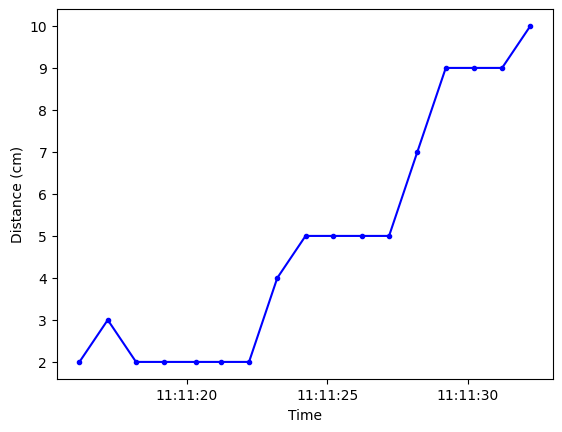

11:11:33  →  9.00 cm


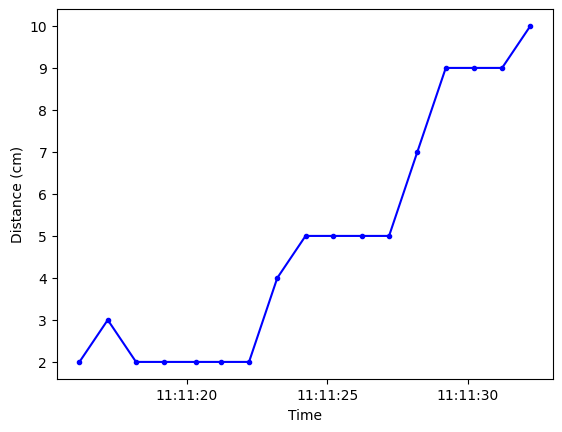

❎ Disconnected


In [14]:
# BLE Distance Logger Notebook

import asyncio
from bleak import BleakScanner, BleakClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, clear_output

# === Configuration ===
DEVICE_NAME = "M5StampS3_Logger"
CHAR_UUID = "beb5483e-36e1-4688-b7f5-ea07361b26a8"
CSV_FILE = r"C:\Users\brand\OneDrive\Documents\Arduino\distance_log.csv"

# === Step 1: Scan for devices ===
async def find_esp32(name_filter):
    print("🔍 Scanning for BLE devices...")
    devices = await BleakScanner.discover(timeout=5.0)
    for d in devices:
        print(f"{d.name} - {d.address}")
        if d.name == name_filter:
            print(f"\n✅ Found ESP32 device: {d.name} @ {d.address}")
            return d.address
    print("\n❌ ESP32 not found. Make sure it’s powered on and advertising.")
    return None

# === Step 2: Receive and log notifications ===
distances = []

def notification_handler(sender, data):
    try:
        value = float(data.decode("utf-8"))
        timestamp = datetime.now()
        distances.append((timestamp, value))
        print(f"{timestamp.strftime('%H:%M:%S')}  →  {value:.2f} cm")

        # Append to CSV
        pd.DataFrame([[timestamp, value]], columns=["Time", "Distance"]).to_csv(
            CSV_FILE, mode='a', index=False, header=False)
    except Exception as e:
        print("Decode error:", e)

async def connect_and_log(address):
    async with BleakClient(address) as client:
        print(f"\nConnected to {address}? {client.is_connected}")
        await client.start_notify(CHAR_UUID, notification_handler)
        print("📡 Listening for distance updates... (Press Stop ▶ in Jupyter to end)")

        # Live plot
        plt.ion()
        fig, ax = plt.subplots()
        line, = ax.plot([], [], 'b.-')
        ax.set_xlabel("Time")
        ax.set_ylabel("Distance (cm)")

        try:
            while True:
                await asyncio.sleep(1)
                if distances:
                    times, vals = zip(*distances)
                    ax.clear()
                    ax.plot(times, vals, 'b.-')
                    ax.set_xlabel("Time")
                    ax.set_ylabel("Distance (cm)")
                    clear_output(wait=True)
                    display(fig)
        except asyncio.CancelledError:
            pass
        finally:
            await client.stop_notify(CHAR_UUID)
            plt.ioff()
            plt.show()
            print("❎ Disconnected")

# === Step 3: Main async flow ===
async def main():
    address = await find_esp32(DEVICE_NAME)
    if address:
        await connect_and_log(address)

# === Run it ===
await main()
